<a href="https://colab.research.google.com/github/KvKavindu/Car-damage-detection/blob/main/KNN_and_CNN_for_damage_detection_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is the notebook that demonstrates how to classify labeled car damage images using KNN & CNN
algorithm**

This notebook loads the car damage dataset from the google drive.Then applies KNN algorithm and Custome CNN algorithm and show results


We will load the dataset from the google drive. For that we import google colab library .

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Lets **list** the folder in our dataset ,here the folder is car-damage

In [ ]:
!ls /content/gdrive/My\ Drive/datasets/car-damage

damage	undamage


Here is the class SimpleDatasetLoader which loads the dataset fom the drive and it gives data and label,which are tuple of numpy array of data and labels

# Implement SimpleDatasetLoader

In [ ]:
#Class to load the dataset images from drivce
import os
import cv2
import numpy as np


class SimpleDatasetLoader:
    # Method: Constructor
    def __init__(self, preprocessors=None):
        """
        :param preprocessors: List of image preprocessors
        """
        self.preprocessors = preprocessors

        if self.preprocessors is None:
            self.preprocessors = []

    # Method: Used to load a list of images for pre-processing
    def load(self, image_paths, verbose=-1):
        """
        :param image_paths: List of image paths
        :param verbose: Parameter for printing information to console
        :return: Tuple of data and labels
        """
        data, labels = [], []

        for i, image_path in enumerate(image_paths):
            image = cv2.imread(image_path)
            label = image_path.split(os.path.sep)[-2]

            if self.preprocessors is not None:
                for p in self.preprocessors:
                    image = p.preprocess(image)

            data.append(image)
            labels.append(label)

            if verbose > 0 and i > 0 and (i+1) % verbose == 0:
                print('[INFO]: Processed {}/{}'.format(i+1, len(image_paths)))

        return (np.array(data), np.array(labels))






Machine learning algorithm such as k-NN require all images in a dataset to have a **fixed feature vector size**.

In the case of images, this
requirement implies that our images must be preprocessed and scaled to have identical widths and heights.

There are a number of ways to accomplish this resizing and scaling, ranging from more advanced methods that respect the aspect ratio of the original image to the scaled image to simple methods that ignore the aspect ratio and simply squash the width and height to the required dimensions

class SimplePreprocessor builds an image preprocessor that resizes
the image, ignoring the aspect ratio.


#Implementing SimplePreprocessor

In [ ]:
#Class Preprocessror
class SimplePreprocessor:
    # Method: Constructor
    def __init__(self, width, height, interpolation=cv2.INTER_AREA):
        """
        :param width: Image width
        :param height: Image height
        :param interpolation: Interpolation algorithm
        """
        self.width = width
        self.height = height
        self.interpolation = interpolation

    # Method: Used to resize the image to a fixed size (ignoring the aspect ratio)
    def preprocess(self, image):
        """
        :param image: Image
        :return: Re-sized image
        """
        return cv2.resize(image, (self.width, self.height), interpolation=self.interpolation)

# Implement k-NN Classifier

---
• Step #1 –**Gather Our Dataset** : The datasets consists of 750 images with 605 and 146 damaged and undamaged images respectively. Each image is represented in the RGB color space. We will preprocess each image by resizing it to 32 × 32 pixels. Taking into account the three RGB channels, the resized image dimensions imply that each image in the dataset is represented by 32 × 32 × 3 = 3, 072 integers.

• Step #2 – **Split the Dataset**: We will split the data, One split for training, and the other for testing.

• Step #3 – **Train the Classifier**: Our k-NN classifier will be trained on the raw pixel intensities of the images in the training set.

• Step #4 – **Evaluate**: Once our k-NN classifier is trained, we can evaluate performance on the test set.

In [ ]:

from imutils import paths
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from __main__ import SimplePreprocessor
from __main__ import SimpleDatasetLoader




# Get list of image paths
image_paths = list(paths.list_images("/content/gdrive/My Drive/datasets/car-damage"))

# Initialize SimplePreprocessor and SimpleDatasetLoader and load data and labels
print('[INFO]: Images loading....')
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(image_paths, verbose=500)

# Reshape from (32, 32, 3) to (32*32*3=3072)
data = data.reshape((data.shape[0], 3072))

# Print information about memory consumption
print('[INFO]: Features Matrix: {:.1f}MB'.format(float(data.nbytes / 1024*1000.0)))

# Encode labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split data into training (75%) and testing (25%) data
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.25, random_state=42)

# Train and evaluate the k-NN classifier on the raw pixel intensities
print('[INFO]: Classification starting....')
model = KNeighborsClassifier(n_neighbors=7,
                             n_jobs=1)
model.fit(train_x, train_y)
print(classification_report(test_y, model.predict(test_x),
                            target_names=le.classes_))

print('[INFO]: Classification based on kd_tree')
model = KNeighborsClassifier(n_neighbors=7,
                             n_jobs=1,algorithm='kd_tree')
model.fit(train_x, train_y)
print(classification_report(test_y, model.predict(test_x),
                            target_names=le.classes_))

[INFO]: Images loading....
[INFO]: Processed 500/751
[INFO]: Features Matrix: 2253000.0MB
[INFO]: Classification starting....
              precision    recall  f1-score   support

      damage       0.77      1.00      0.87       143
    undamage       1.00      0.04      0.09        45

    accuracy                           0.77       188
   macro avg       0.88      0.52      0.48       188
weighted avg       0.82      0.77      0.68       188

[INFO]: Classification based on kd_tree
              precision    recall  f1-score   support

      damage       0.77      1.00      0.87       143
    undamage       1.00      0.04      0.09        45

    accuracy                           0.77       188
   macro avg       0.88      0.52      0.48       188
weighted avg       0.82      0.77      0.68       188



The construction of a KD tree is very fast.

# How to find Best K?

In [ ]:
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np

model = KNeighborsClassifier(n_neighbors=2,n_jobs=1)
model.fit(train_x, train_y)

accuracy = accuracy_score(model.predict(test_x), test_y)
print(accuracy)
n_neighbors = np.array([7,8,9,10,12,15,20])
param_grid = dict(n_neighbors=n_neighbors)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(train_x, train_y)
print(grid.best_score_)
print(grid.best_estimator_.n_neighbors)

0.7712765957446809
0.8223767383059417
7


K=7 Neighbours gives best score.

Classifying a new testing point
requires a comparison to every single data point in our training data, which scales O(N), making
working with larger datasets computationally prohibitive.

**Convolutional Neural Network**

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
modelCNN = models.Sequential()
modelCNN.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
modelCNN.add(layers.MaxPooling2D((2, 2)))
modelCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelCNN.add(layers.MaxPooling2D((2, 2)))
modelCNN.add(layers.Conv2D(64, (3, 3), activation='relu'))
modelCNN.add(layers.Flatten())
modelCNN.add(layers.Dense(64, activation='relu'))
modelCNN.add(layers.Dense(2))

In [ ]:
modelCNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 1024)             

In [ ]:
from imutils import paths
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from __main__ import SimplePreprocessor
from __main__ import SimpleDatasetLoader


# Get list of image paths
image_paths = list(paths.list_images("/content/gdrive/My Drive/datasets/car-damage"))

# Initialize SimplePreprocessor and SimpleDatasetLoader and load data and labels
print('[INFO]: Images loading....')
sp = SimplePreprocessor(32, 32)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(dataC, labels) = sdl.load(image_paths, verbose=500)

# Reshape from (3000, 32, 32, 3) to (3000, 32*32*3=3072)
#dataC = dataC.reshape((data.shape[0], 3072))

# Print information about memory consumption
print('[INFO]: Features Matrix: {:.1f}MB'.format(float(dataC.nbytes / 1024*1000.0)))

# Encode labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split data into training (75%) and testing (25%) data
(train_x, test_x, train_y, test_y) = train_test_split(dataC, labels, test_size=0.25, random_state=42)

# Train and evaluate the k-NN classifier on the raw pixel intensities
print('[INFO]: CNN Classification starting....')

modelCNN.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = modelCNN.fit(train_x, train_y, epochs=20,
                    validation_data=(test_x, test_y))


[INFO]: Images loading....
[INFO]: Processed 500/751
[INFO]: Features Matrix: 2253000.0MB
[INFO]: CNN Classification starting....
Epoch 1/20
18/18 [==============================] - 2s 63ms/step - loss: 0.4249 - accuracy: 0.8472 - val_loss: 0.7890 - val_accuracy: 0.7287
Epoch 2/20
18/18 [==============================] - 1s 56ms/step - loss: 0.3044 - accuracy: 0.8917 - val_loss: 0.5620 - val_accuracy: 0.7660
Epoch 3/20
18/18 [==============================] - 1s 52ms/step - loss: 0.2034 - accuracy: 0.9183 - val_loss: 0.7108 - val_accuracy: 0.7553
Epoch 4/20
18/18 [==============================] - 1s 51ms/step - loss: 0.1937 - accuracy: 0.9396 - val_loss: 0.6919 - val_accuracy: 0.7713
Epoch 5/20
18/18 [==============================] - 1s 51ms/step - loss: 0.1181 - accuracy: 0.9609 - val_loss: 0.7857 - val_accuracy: 0.7500
Epoch 6/20
18/18 [==============================] - 1s 51ms/step - loss: 0.0899 - accuracy: 0.9734 - val_loss: 1.0664 - val_accuracy: 0.7500
Epoch 7/20
18/18 [======

6/6 - 0s - loss: 1.5422 - accuracy: 0.7713 - 94ms/epoch - 16ms/step


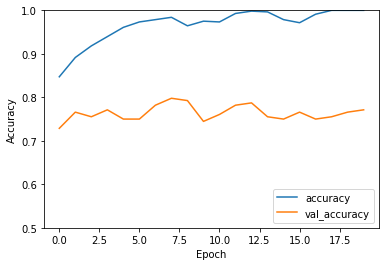

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = modelCNN.evaluate(test_x,  test_y, verbose=2)